In [1]:
###################################################
# STILL MISSING
#
# - Radiation Domination (beta > beta_c)
# - Mass functions
###################################################

In [6]:
using Pkg
Pkg.activate("./")
Pkg.instantiate()

using DelimitedFiles
using Integrals
using Interpolations
using Trapz
using SciPy
using LaTeXStrings

  Activating project at `~/Nextcloud/Promotion/OP3PGN/Evaporation/DarkMatterProduction`


In [3]:
#Loading the code...

include("../Code/units.jl") #Units and definitions
include("../Code/data.jl") #Data from BlackHawk, Constraints and others
include("../Code/interpolation.jl") #Routines for interpolation
include("../Code/cosmology.jl") #Cosmological background
include("../Code/technical.jl") #Some stuff...
include("../Code/evaporation.jl") #Main module which contains the evaporation physics
include("../Code/constraints.jl") #Functions to obtain constraints on f_PBH

constraint_k_bbn_ext (generic function with 1 method)

In [70]:
#BLACK HOLE PARAMETERS

m0s = mp*[1e5,1e5] #BH mass in gram
ks = [0.75,0.75] #Burden exponent
qs = [0.5,0.5] #Burden q (when memory burden sets in)
bursts = [false,false] #Whether T~const. or T~1/M during memory burden
a_bh = 0.0 #Value of initial BH spin parameter
two_stages = true #Whether to include two stages of the evaporation (does not work with fit!)

#PARTICLE DM PARAMETERS

m_ncdms = [0.01,0.01] #DM mass in GeV
s = 0.5 #Spin of DM particle
g = 1 #DOF of DM particle

#COMOLOGICAL PARAMETERS

#Specify one of the following three parameters:
β = nothing #Initial PBH density fraction. If set to nothing, f is used.
f = nothing #Initial PBH dark matter fraciton. If set to nothing then Ω_ncdm is used.
Ω_ncdm = 0.12 #If set to nothing, then it is computed.

Ω_dm = 0.1201075 #Total dark matter density

#PSD PARAMETERS

use_fits = [false,true] #Whether to use a PSD file or an analytical expression

n_e_class = 200 #Number of values for q=E/T for CLASS
q_min_class = 0.01 #Minimum value for q=E/T for CLASS
q_max_class = 100 #Maximum value for q=E/T for CLASS
n_e = 1000 #Number of values for q=E/T for CLASS
q_min = 1e-4 #Minimum value for q=E/T for plots and fitting
q_max = 1e3 #Maximum value for q=E/T for plots and fitting

1000.0


m=2.17645g, q=0.5, k=0.75, burst=false, m_dm=0.01 GeV
First stage
T_ncdm 204.35253503186428
Ω_ncdm 0.072
Deviation of mean momentum: 0.2592 %
Deviation of rms momentum: 0.2225 %
Second stage
T_ncdm2 2.311330936531744e6
Deviation of mean momentum: 0.01329 %
Deviation of rms momentum: 0.1072 %
Ω_ncdm2 0.048
Using psd file

Running CLASS...
Reading input parameters
 -> matched budget equations by adjusting Omega_Lambda = 0.690026
Running CLASS version v3.2.3
Computing background
 -> ncdm species i=1 read from file ../Input/psd_1_sc.dat
 -> non-cold dark matter species with i=1 has m_i = 1.000000e+07 eV (so m_i / omega_i =6.726284e-05 eV)
 -> ncdm species i=1 sampled with 16 (resp. 10) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 0.000481836
 -> ncdm species i=2 read from file ../Input/psd_1_mb.dat
 -> non-cold dark matter species with i=2 has m_i = 1.000000e+07 eV (so m_i / omega_i =4.266105e-17 eV)
 -> ncdm species i

sys:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


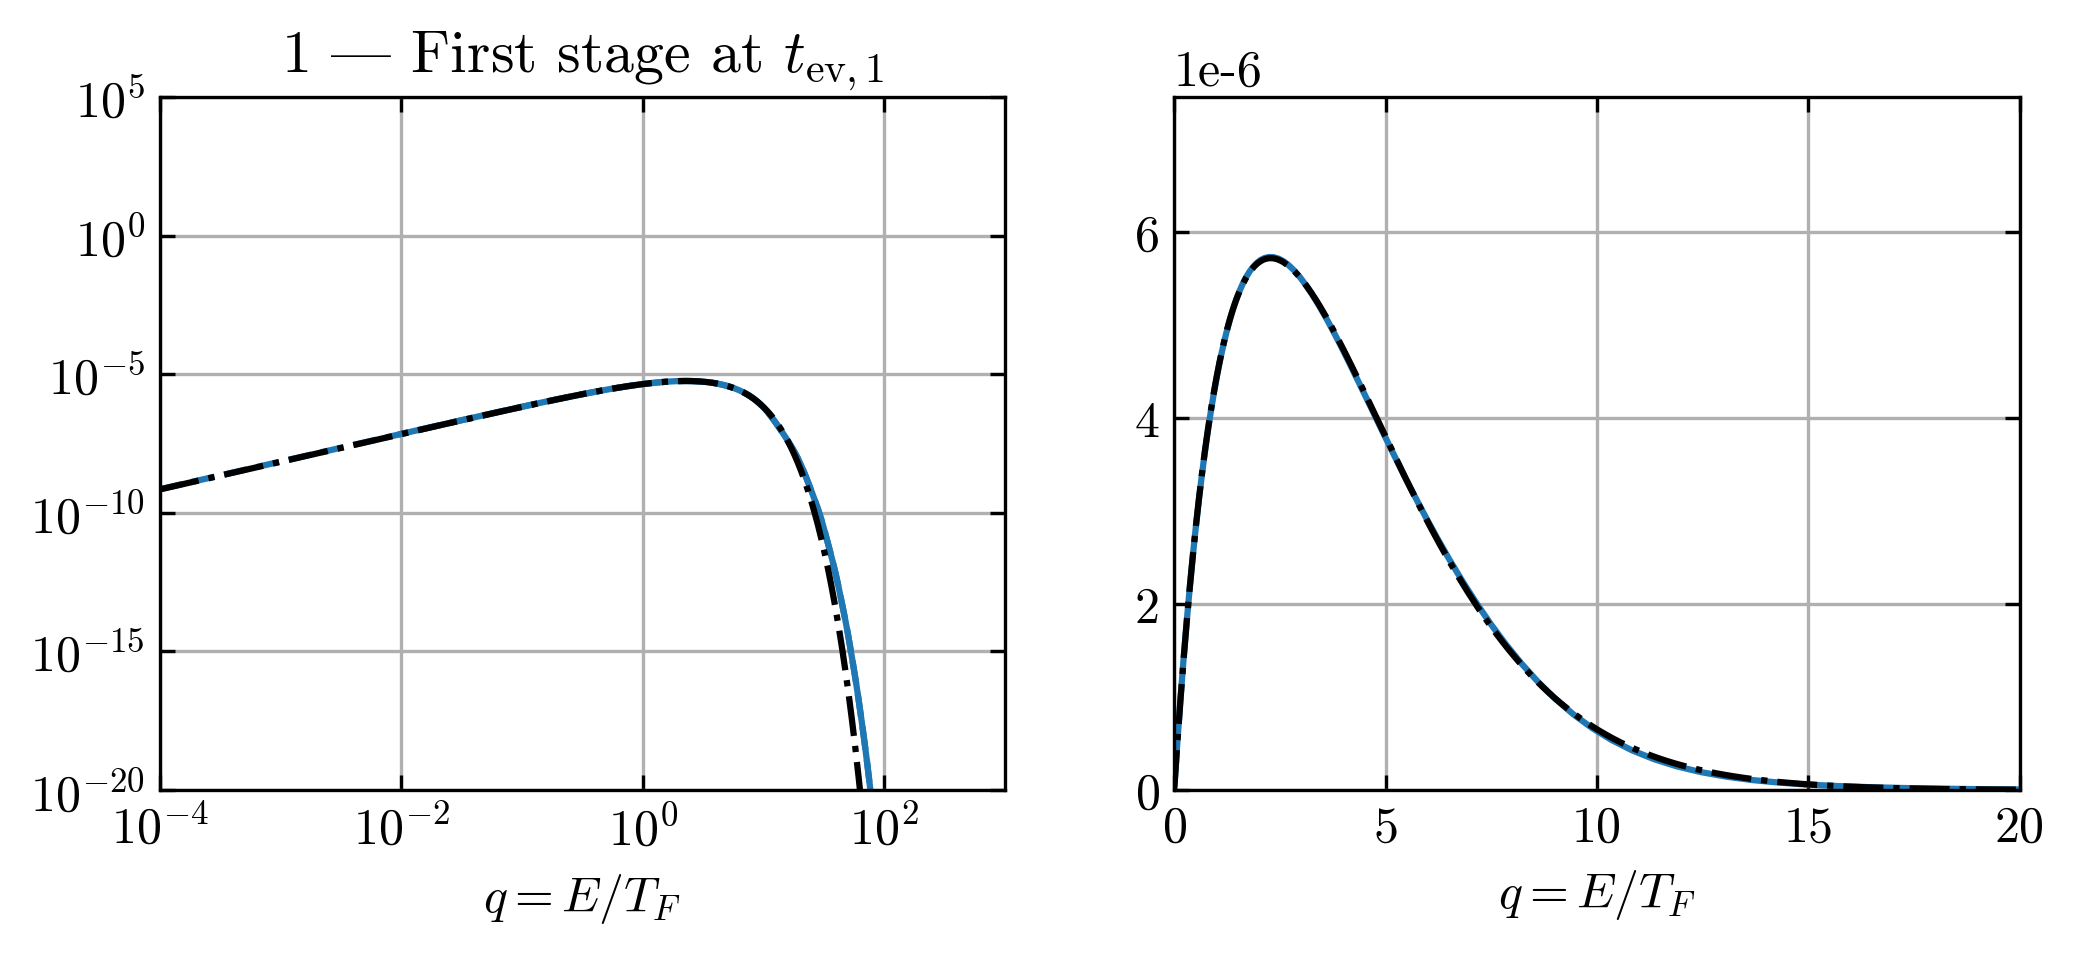

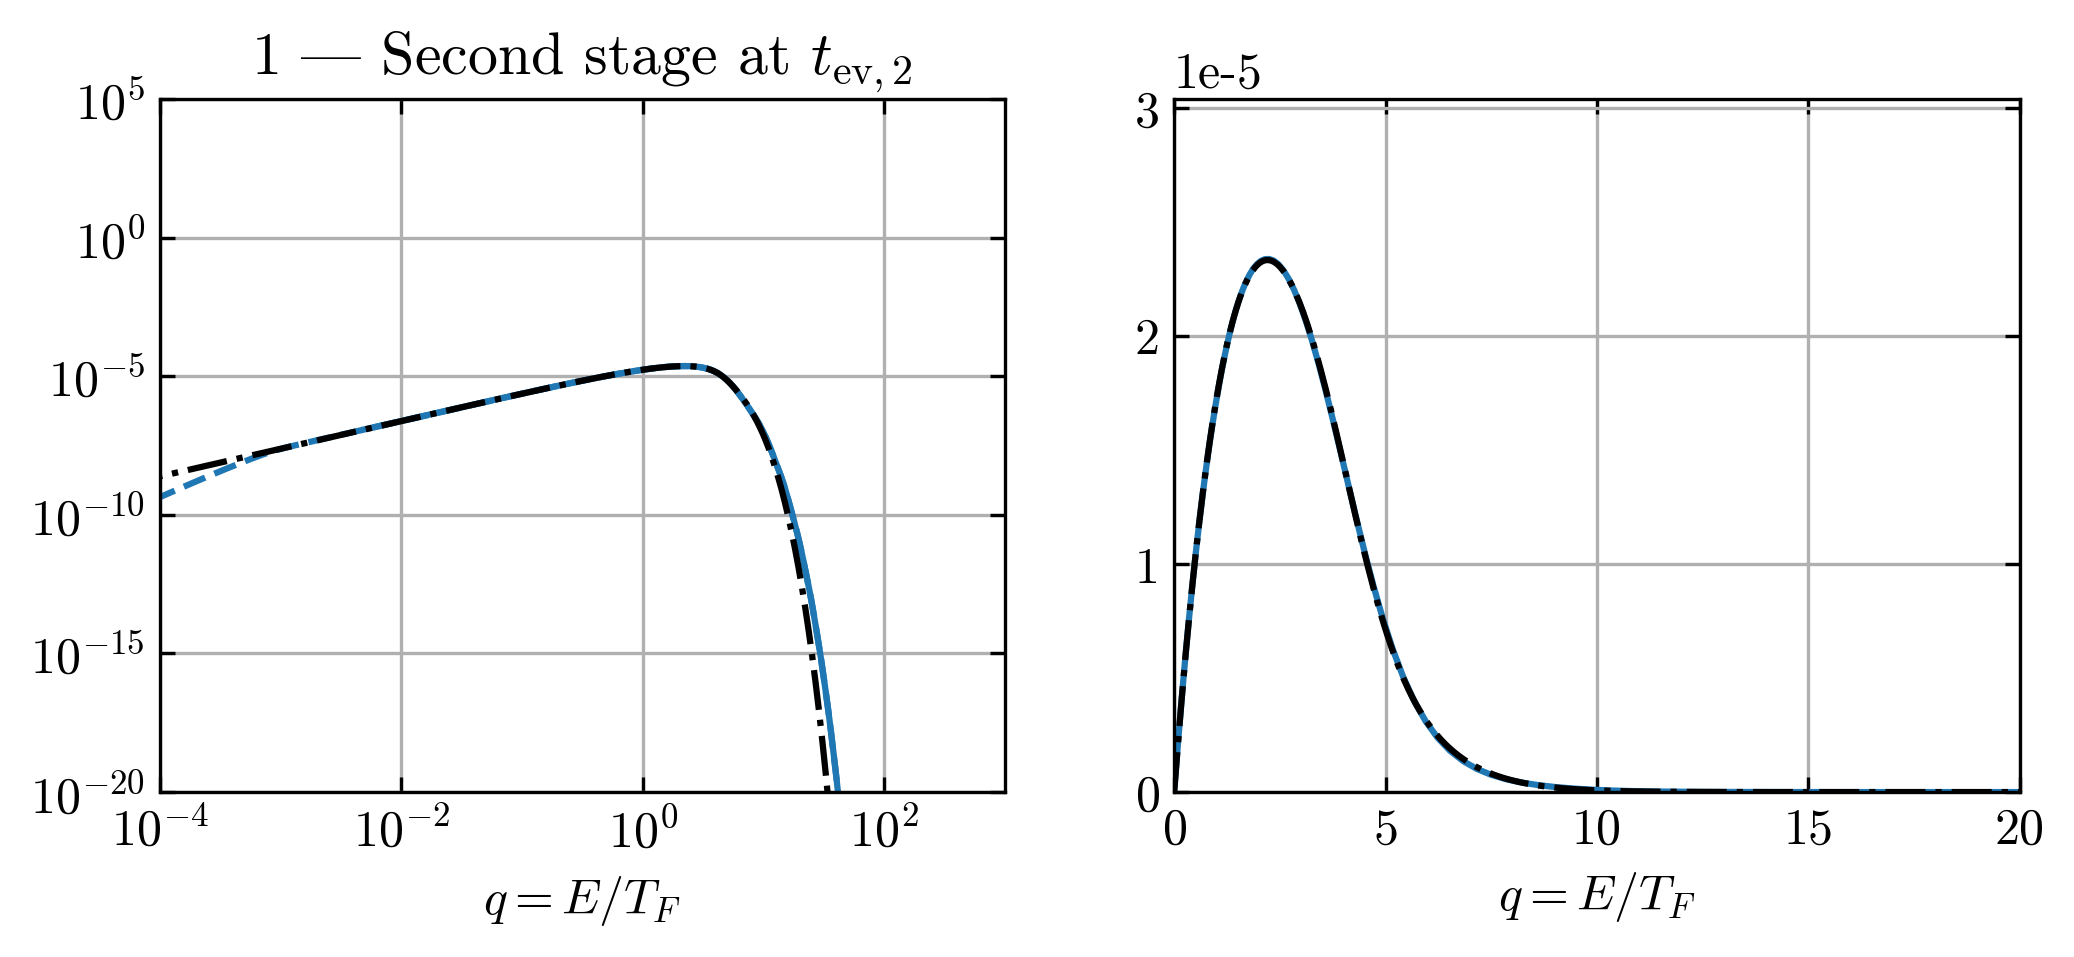

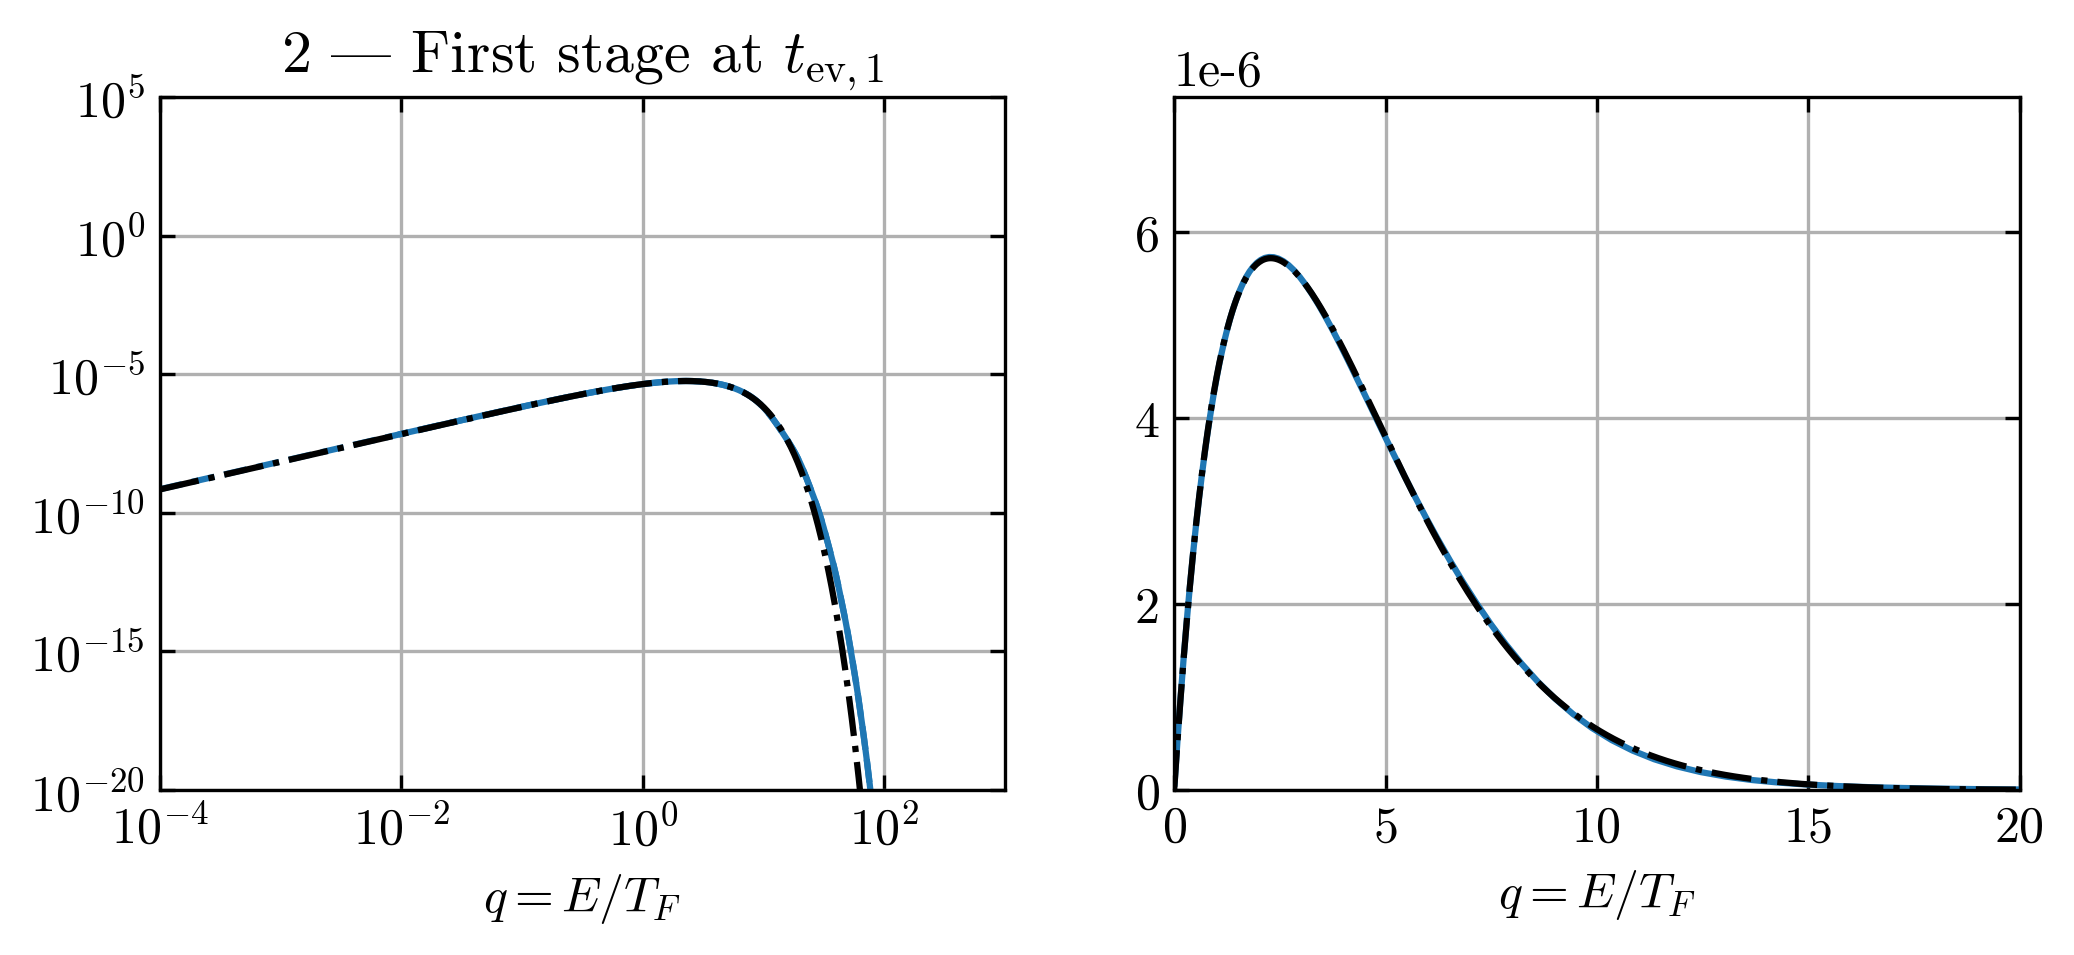

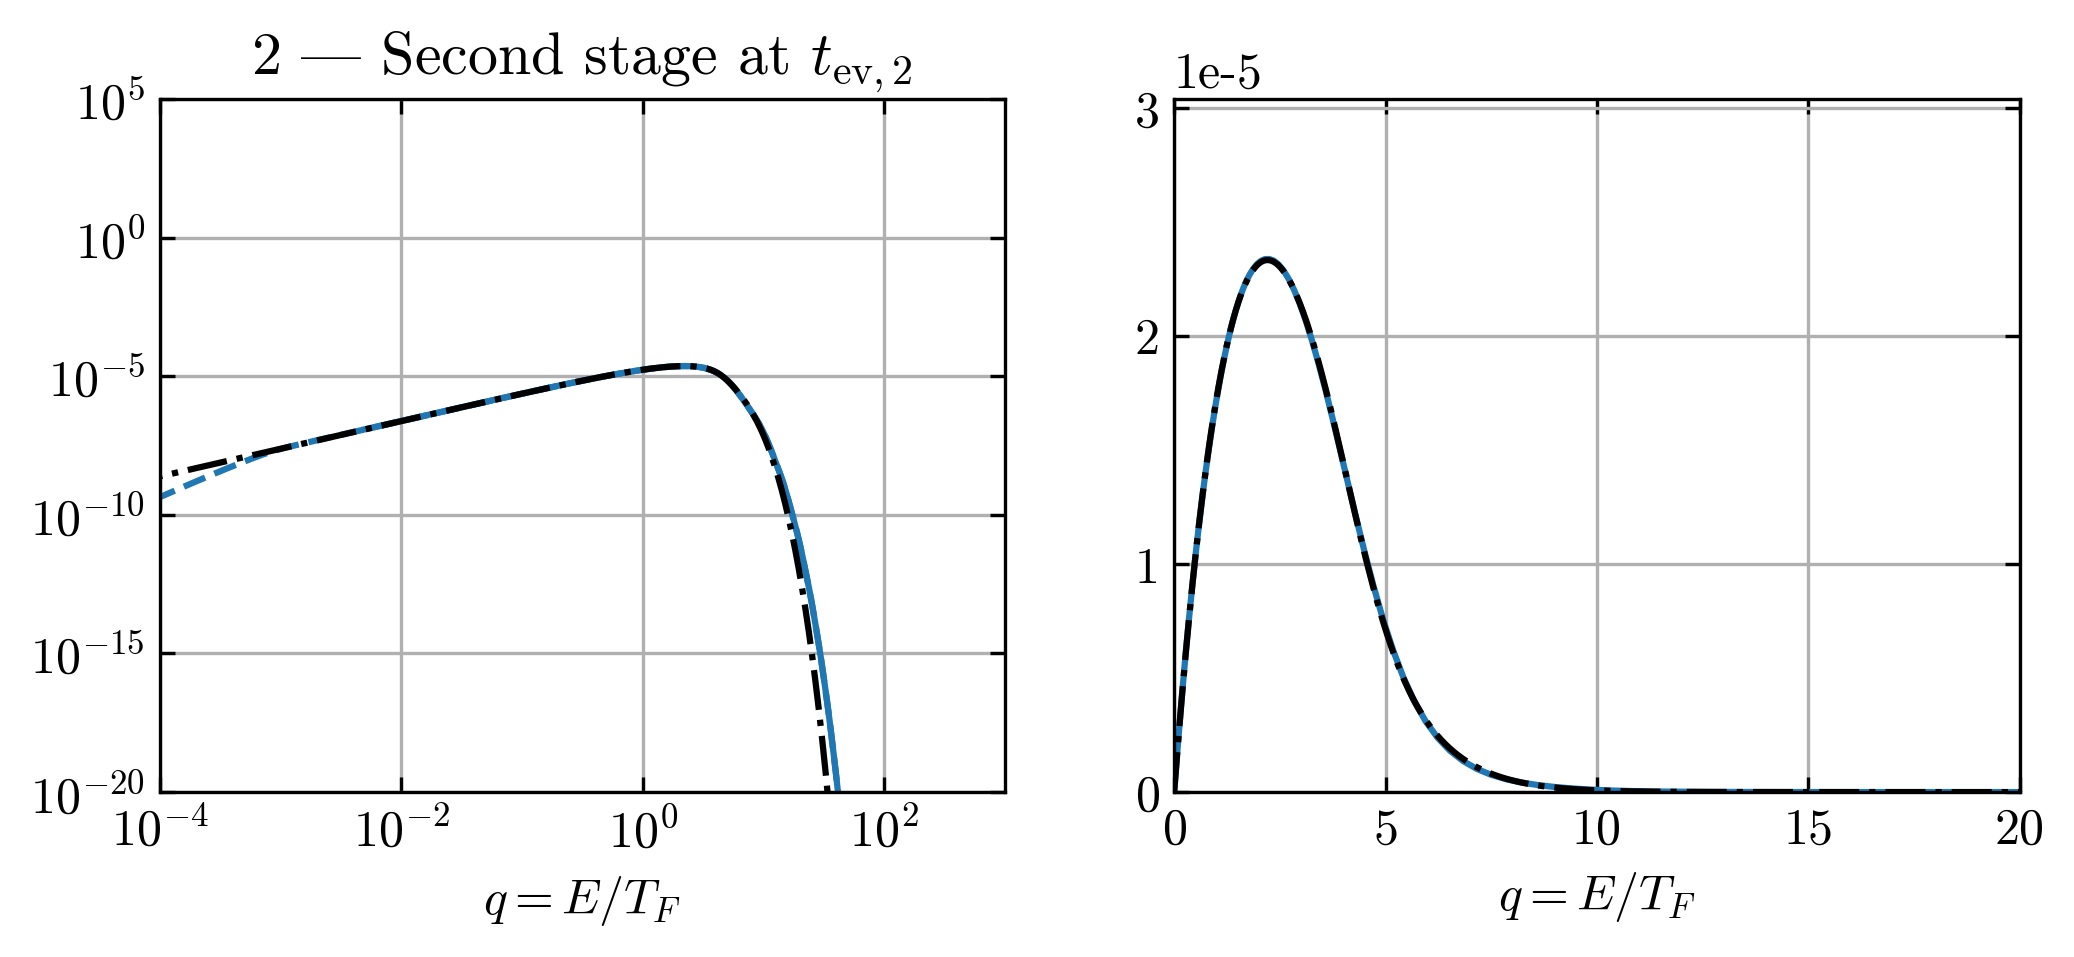

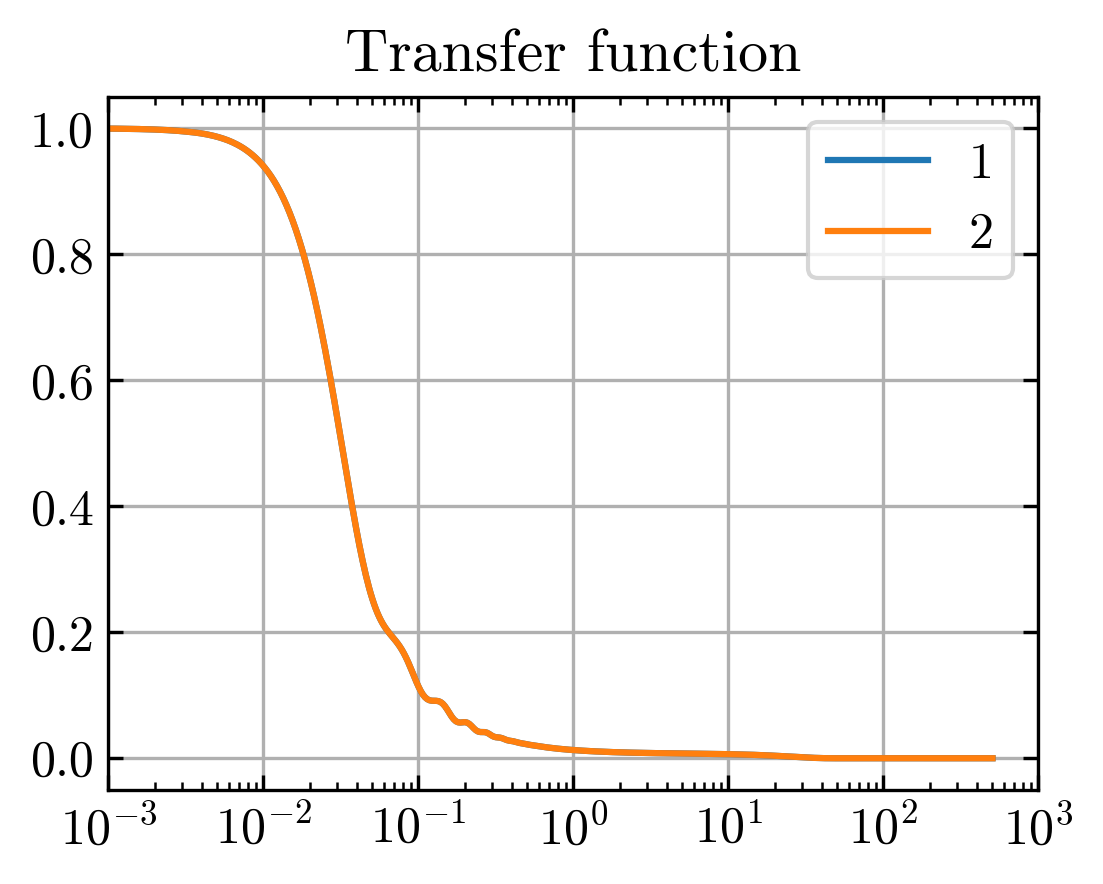

In [71]:
if create_plots
    using PyPlot
    rcdefaults()
    rc("figure",dpi=300,figsize=(4,3))
    rc("font",size=12,family="serif",serif="cmr10")
    rc("mathtext",fontset="cm")
    rc("axes",unicode_minus=false)
    rc("xtick",direction="in",top=true)
    rc("ytick",direction="in",right=true)
    rc("savefig",bbox="tight")
    ion()
end

area = zeros(length(m0s))

for i=1:length(m0s)

    parameters = []
    
    m0 = m0s[i]
    q = qs[i]
    k = ks[i]
    m_ncdm = m_ncdms[i]
    burst = bursts[i]
    use_fit = use_fits[i]

    println()
    println("m=",m0,"g, q=",q,", k=",k,", burst=",burst,", m_dm=",m_ncdm," GeV")
    println("First stage")

    T0 = bh_temp(m0)

    e = 10 .^ LinRange(log10(T0*q_min),log10(T0*q_max),n_e)
    e_class = 10 .^ LinRange(log10(T0*q_min_class),log10(T0*q_max_class),n_e_class)

    t_start = bh_formation(m0)
    t_end = bh_lifetime_estimate(m0,a_bh,m_fin=q*m0)

    a_end = t_to_a(t_end)
    #a_end_approx = 3.33e-31 * (1-q^3)^(1/2)*(m0/mp)^(3/2)
    #println("aev_1 ",abs(1-a_end/a_end_approx))
    
    T_ncdm = T0*GeV_to_K/2.7255*a_end
    println("T_ncdm ",T_ncdm)
    #T_ncdm_approx = 0.69054 * (1-q^3)^(1/2) *(m0/mp)^(1/2)

    Φ1, Φ2 = spectrum_redshift(e,m0,s,g,a_bh,
        t_start=t_start,t_end=t_end,go=false,k=k,burst=burst,q=q,instant=false,n_steps=1000,split_flux=true)
    Φ1_class, Φ2_class = spectrum_redshift(e_class,m0,s,g,a_bh,
        t_start=t_start,t_end=t_end,go=false,k=k,burst=burst,q=q,instant=false,n_steps=1000,split_flux=true)

    N1 = trapz(e,Φ1)
    #N1_approx = 2.85e-2*m0^2/mp^2*(1-q^2)
    #println("N_1 ",abs(1-N1/N1_approx))
    
    if !isnothing(β)
        Ω1 = N1 * m_ncdm * GeV_to_g * 0.26 * f_βm(β,m0) / m0
        Ω1_approx = 2.85e-2 * m0 * m_ncdm*GeV_to_g / mp^2 * 0.26 * f_βm(β,m0) * (1 - q^2)
        println("Deviation of Ω_ncdm ",round(100*abs(1-Ω1_approx/Ω1),sigdigits=4)," %")
    elseif !isnothing(f)
        Ω1 = N1 * m_ncdm * GeV_to_g * 0.26 * f / m0
        Ω1_approx = 2.85e-2 * m0 * m_ncdm*GeV_to_g / mp^2 * 0.26 * f * (1 - q^2)
        println("Deviation of Ω_ncdm ",round(100*abs(1-Ω1_approx/Ω1),sigdigits=4)," %")
    elseif burst
        Ω1 = Ω_ncdm * (1-q^2)
    else
        Ω1 = Ω_ncdm * (1-q^2)/(1+q^2)
    end
    
    println("Ω_ncdm ",Ω1)

    ff(x,a,b,c,d,e) = spectrum_redshift_approximation.(x,bh_lifetime_estimate(m0,a_bh,m_fin=q*m0),bh_lifetime_estimate(m0,a_bh,k=k,burst=burst,q=q),a,b,c,d,e)
    fit = optimize.curve_fit(ff,e/T0,Φ1*T0^3/(mp*g_to_GeV)^2,[1,1,1,1,1])
    Φ_fit = ff.(e/T0,fit[1]...)
    
    
    p_mean = trapz(e/T0,e/T0 .* Φ1)/trapz(e/T0,Φ1)
    p_mean_approx = trapz(e/T0,e/T0  .* Φ_fit)/trapz(e/T0,Φ_fit)
    p_mean1_err = round(100*abs(1-p_mean_approx/p_mean),sigdigits=4)
    println("Deviation of mean momentum: ",p_mean1_err," %")

    p_rms = sqrt(trapz(e/T0,(e/T0).^2 .* Φ1)/trapz(e/T0,Φ1))
    p_rms_approx = sqrt(trapz(e/T0,(e/T0).^2  .* Φ_fit)/trapz(e/T0,Φ_fit))
    p_rms1_err = round(100*abs(1-p_rms_approx/p_rms),sigdigits=4)
    println("Deviation of rms momentum: ",p_rms1_err," %")
    flush(stdout)
    
    fig = figure(figsize=(8,3))
    ax = subplot(121)
    p = loglog(e/T0, (T0^3/(mp*g_to_GeV)^2)*Φ1,"--")
    plot(e_class/T0, (T0^3/(mp*g_to_GeV)^2)*Φ1_class,color=p[1].get_color())
    plot(e/T0,Φ_fit,"-.",color="black")
    ylim(1e-20,1e5)
    xlim(q_min,q_max)
    grid()
    xlabel(L"q = E/T_F")
    title(L"%$(i) | First stage at $t_{\rm ev,1}$")
        
    ax = subplot(122)
    plot(e_class/T0, (T0^3/(mp*g_to_GeV)^2)*Φ1_class)
    plot(e/T0,Φ_fit,"-.",color="black")
    ylim(0,maximum((T0^3/(mp*g_to_GeV)^2)*Φ1_class)*1.3)
    xlim(0,20)
    grid()
    xlabel(L"q = E/T_F")
    show()
    savefig(string("Plots/",i,"_sc.png"))
    
    writedlm(string("Input/psd_",i,"_sc.dat"),[e_class/T0 (T0^3/(mp*g_to_GeV)^2)*Φ1_class])
    
    if two_stages
        
        println("Second stage")
        if use_fit
            println("Two stages do not work with fit! Psd file is used...")
        end
    
        T0 = T0/q

        t_end2 = bh_lifetime_estimate(m0,a_bh,k=k,burst=burst,q=q)

        a_end2 = t_to_a(t_end2)
        #if burst
        #    a_end2_approx = 3.336e-31 * 12.567^(k/2) * q^(3/2+k) * (m0/mp)^(3/2+k) / sqrt(1+2/3*k)
        #else
        #    a_end2_approx = 3.336e-31 * 12.567^(k/2) * q^(3/2+k) * (m0/mp)^(3/2+k) * sqrt(3)
        #end
        #println("aev_2 ",abs(1-a_end2/a_end2_approx))

        T_ncdm2 = T0*GeV_to_K/2.7255*a_end2
        println("T_ncdm2 ",T_ncdm2)
        #if burst
        #    T_ncdm2_approx = 0.6905 * 12.567^(k/2) * q^(1/2+k) * (m0/mp)^(1/2 + k) / sqrt(1 + 2/3*k)
        #else
        #    T_ncdm2_approx = 0.6905 * 12.567^(k/2) * q^(1/2+k) * (m0/mp)^(1/2 + k) * sqrt(3)
        #end
        #println("Tncdm_2 ",abs(1-T_ncdm2/T_ncdm2_approx))


        Φ1, Φ2 = spectrum_redshift(e,m0,s,g,a_bh,
            t_start=t_start,t_end=t_end2,go=false,k=k,burst=burst,q=q,instant=false,n_steps=1000,split_flux=true)
        Φ1_class, Φ2_class = spectrum_redshift(e_class,m0,s,g,a_bh,
            t_start=t_start,t_end=t_end2,go=false,k=k,burst=burst,q=q,instant=false,n_steps=1000,split_flux=true)

        N2 = trapz(e,Φ2)
        #if burst
        #    N2_approx = 2.85e-2*m0^2/mp^2*q^2
        #else
        #    N2_approx = 2.85e-2*2*m0^2/mp^2*q^2
        #end
        #Ntot_approx = 2.85e-2*m0^2/mp^2*(1+q^2)

        if !isnothing(β)
            Ω2 = N2 * m_ncdm * GeV_to_g * 0.26 * f_βm(β,m0) / m0
            Ω2_approx = 2.85e-2 * m0 * m_ncdm*GeV_to_g / mp^2 * 0.26 * f_βm(β,m0) * q^2
            if !burst
                Ω2_approx *= 2
            end
            println("Deviation of Ω_ncdm ",round(100*abs(1-Ω1_approx/Ω1),sigdigits=4)," %")
        elseif !isnothing(f)
            Ω2 = N2 * m_ncdm * GeV_to_g * 0.26 * f / m0
            Ω2_approx = 2.85e-2 * m0 * m_ncdm*GeV_to_g / mp^2 * 0.26 * f * q^2
            if !burst
                Ω2_approx *= 2
            end
            println("Deviation of Ω_ncdm ",round(100*abs(1-Ω1_approx/Ω1),sigdigits=4)," %")
        elseif burst
            Ω2 = Ω_ncdm * q^2
        else
            Ω2 = 2 * Ω_ncdm * q^2/(1+q^2)
        end

        println("Ω_ncdm2 ",Ω2)
    
        ff(x,a,b,c,d,e) = spectrum_redshift_approximation.(x,bh_lifetime_estimate(m0,a_bh,m_fin=q*m0),bh_lifetime_estimate(m0,a_bh,k=k,burst=burst,q=q),a,b,c,d,e)
        fit2 = optimize.curve_fit(ff,e/T0,Φ2*T0^3/(mp*g_to_GeV)^2,[1,1,1,1,1])
        Φ_fit2 = ff.(e/T0,fit2[1]...)

        p_mean2 = trapz(e/T0,e/T0 .* Φ2)/trapz(e/T0,Φ2)
        p_mean_approx2 = trapz(e/T0,e/T0  .* Φ_fit2)/trapz(e/T0,Φ_fit2)
        p_mean_err2 = round(100*abs(1-p_mean_approx2/p_mean2),sigdigits=4)
        println("Deviation of mean momentum: ",p_mean_err2," %")

        p_rms2 = sqrt(trapz(e/T0,(e/T0).^2 .* Φ2)/trapz(e/T0,Φ2))
        p_rms_approx2 = sqrt(trapz(e/T0,(e/T0).^2  .* Φ_fit2)/trapz(e/T0,Φ_fit2))
        p_rms_err2 = round(100*abs(1-p_rms_approx2/p_rms2),sigdigits=4)
        println("Deviation of rms momentum: ",p_rms_err2," %")
        flush(stdout)
    
        fig = figure(figsize=(8,3))
        ax = subplot(121)
        p = loglog(e/T0, (T0^3/(mp*g_to_GeV)^2)*Φ2,"--")
        plot(e_class/T0, (T0^3/(mp*g_to_GeV)^2)*Φ2_class,color=p[1].get_color())
        plot(e/T0,Φ_fit2,"-.",color="black")
        ylim(1e-20,1e5)
        xlim(q_min,q_max)
        grid()
        xlabel(L"q = E/T_F")
        title(L"%$(i) | Second stage at $t_{\rm ev,2}$")

        ax = subplot(122)
        plot(e_class/T0, (T0^3/(mp*g_to_GeV)^2)*Φ2_class)
        plot(e/T0,Φ_fit2,"-.",color="black")
        ylim(0,maximum((T0^3/(mp*g_to_GeV)^2)*Φ2_class)*1.3)
        xlim(0,20)
        grid()
        xlabel(L"q = E/T_F")
        show()
        savefig(string("Plots/",i,"_mb.png"))
        
        writedlm(string("Input/psd_",i,"_mb.dat"),[e_class/T0 (T0^3/(mp*g_to_GeV)^2)*Φ2_class])
    
        push!(parameters,"NNCDM")
        push!(parameters,2)
        push!(parameters,"DEGNCDM")
        push!(parameters,"1,1")
        push!(parameters,"MNCDM")
        push!(parameters,string(m_ncdm*1e9,",",m_ncdm*1e9))
        push!(parameters,"TNCDM")
        push!(parameters,string(T_ncdm,",",T_ncdm2))
        push!(parameters,"OMEGANCDM")
        push!(parameters,string(Ω1,",",Ω2))
        push!(parameters,"OMEGACDM")
        push!(parameters,Ω_dm-Ω1-Ω2)
        push!(parameters,"FITPARAMS")
        push!(parameters,string(fit[1][1],",",fit[1][2],",",fit[1][3],",",fit[1][4],",",fit[1][5]))
        push!(parameters,"PSDFILE")
        push!(parameters,string("../Input/psd_",i,"_sc.dat,../Input/psd_",i,"_mb.dat"))
        println("Using psd file")
        push!(parameters,"USEFILE")
        push!(parameters,"1,1")
    else
        push!(parameters,"NNCDM")
        push!(parameters,1)
        push!(parameters,"DEGNCDM")
        push!(parameters,1)
        push!(parameters,"MNCDM")
        push!(parameters,m_ncdm*1e9)
        push!(parameters,"TNCDM")
        push!(parameters,T_ncdm)
        push!(parameters,"OMEGANCDM")
        push!(parameters,Ω1)
        push!(parameters,"OMEGACDM")
        push!(parameters,Ω_dm-Ω1)
        push!(parameters,"FITPARAMS")
        push!(parameters,string(fit[1][1],",",fit[1][2],",",fit[1][3],",",fit[1][4],",",fit[1][5]))
        push!(parameters,"PSDFILE")
        push!(parameters,string("../Input/psd_",i,"_sc.dat"))
        if use_fit
            println("Using fit")
            push!(parameters,"USEFILE")
            push!(parameters,0)
        else
            println("Using psd file")
            push!(parameters,"USEFILE")
            push!(parameters,1)
        end
    end
    
    println()
    println("Running CLASS...")

    writedlm("param.txt",parameters)
    
    run(`./run.sh param.txt $(i)`)

    println("Computing area criterium...")
    data_cdm = readdlm("Output/CDM00_pk.dat",skipstart=4)
    data_pbh = readdlm(string("Output/",i,"_pk.dat"),skipstart=4)
    cdm_interp = linear_interpolation(log.(data_cdm[:,1]),log.(data_cdm[:,2].*data_cdm[:,1]))
    pbh_interp = linear_interpolation(log.(data_pbh[:,1]),log.(data_pbh[:,2].*data_pbh[:,1]));
    k_ev = 10 .^ LinRange(log10(0.5),log10(20),1000)
    cdm_int = zeros(length(k_ev))
    pbh_int = zeros(length(k_ev))
        
    for i=1:length(k_ev)
        k_int = 10 .^ LinRange(log10(k_ev[i]),log10(500),1000)
        cdm_int[i] = trapz(k_int,exp.(cdm_interp(log.(k_int))))
        pbh_int[i] = trapz(k_int,exp.(pbh_interp(log.(k_int))))
    end
    area[i] = 1 - trapz(k_ev,pbh_int ./ cdm_int)/trapz(k_ev,cdm_int ./ cdm_int)
    println("Area: ",area[i])
    println()
    println("-----------------------------------------------")
    println()
end

writedlm("Output/area_crit.csv",[m0s ks qs bursts m_ncdms use_fits area])


fig = figure()
data_cdm = readdlm("Output/CDM00_pk.dat",skipstart=4)
for i=1:length(m0s)
    data_pbh = readdlm(string("Output/",i,"_pk.dat"),skipstart=4)
    plot(data_pbh[:,1],data_pbh[:,2]./data_cdm[:,2],label=i)
end

xscale("log")
xlim(1e-3,1e3)
grid()
title("Transfer function")
legend()
show()
savefig("Plots/transfer.png")